# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings
import warnings


In [3]:
# Import the libraries you will be using for analysis
# Numerical and Data Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.9.2
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [71]:
# Try loading one file

#df1 = pd.read_parquet('./Dataset/trip_records/2023-1.parquet')
#df1.info()
#df1.head()

#df['tpep_pickup_datetime'].dt.date


How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [73]:
# from google.colab import drive
# drive.mount('/content/drive')

# Select the folder having data files
import os
os.getcwd()

# Select the folder having data files
path="C:\\Ketan\\AI-ML\\upGrad\\EDA-Assignment\\datasets_NYC_taxi\\trip_records\\"
os.chdir(path)
#os.chdir('C:\Ketan\AI-ML\upGrad\EDA-Assignment\datasets_NYC_Taxi\trip_records')
df_month_1 = pd.read_parquet('2023-1.parquet')
df_month_1.info()
df_month_1.head()
# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()

df_month_pq = pd.read_parquet('2023-1.parquet')
df_month_pq.info()
print(df_month_pq.head())
print(df_month_pq['tpep_pickup_datetime'].dt.date.unique())
    #print(trp_file)
#df_month_1.info()
#df_month_1.head()


<class 'pandas.core.frame.DataFrame'>
Index: 3041714 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

In [257]:
# from google.colab import drive
# drive.mount('/content/drive')

# Select the folder having data files
import os
os.getcwd()

# Select the folder having data files
path="C:\\Ketan\\AI-ML\\upGrad\\EDA-Assignment\\datasets_NYC_taxi\\trip_records\\"
os.chdir(path)

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()
df_sampled_data = pd.DataFrame()

#file_list = ['2023-1.parquet']
for trp_file in file_list :

    # load file into df
    print(trp_file)
    df_month_pq = pd.read_parquet(trp_file)
    print('Length of full parquet file ::' + str(len(df_month_pq)))
    
    #df_month_pq.info()
    #print(df_month_pq.head())
    #print(df_month_pq['tpep_pickup_datetime'].dt.date.unique())

    # find yr and month
    yr = int(trp_file.split("-", 1)[0])
    mon = int(trp_file.split("-", 1)[1].split(".",1)[0])
    print(yr)
    print(mon)

    # Keep records of that yr and mon and delete other records.
    #filtered_df_month_pq = df_month_pq[(df_month_pq['tpep_pickup_datetime'].dt.year == yr) & (df_month_pq['tpep_pickup_datetime'].dt.month == mon)]
    filtered_df_month_pq = df_month_pq
    print ('Length of filtered_df_month_pq :: ' + str(len(filtered_df_month_pq)))
    
    # sample records of each day and mon into another df
    for fil_date in filtered_df_month_pq['tpep_pickup_datetime'].dt.date.unique() :
        df_fil_date = filtered_df_month_pq[filtered_df_month_pq['tpep_pickup_datetime'].dt.date == fil_date]
        print ('Length of df_fil_date :: ' + str(len(df_fil_date)))
        
        for fil_hr in df_fil_date['tpep_pickup_datetime'].dt.hour.unique() :
            df_hr_data = df_fil_date[df_fil_date['tpep_pickup_datetime'].dt.hour == fil_hr]

            # sample 0.05 of the hour_data
            # random_state is just a seed for sampling, you can define it yourself
            sample = df_hr_data.sample(frac=0.0075, random_state=42)
            df_sampled_data = pd.concat([df_sampled_data, sample]) # adding data for this hour to the DF
            #print (len(sample))
            #print ('Length of sample :: ' + str(len(sample)))
            #df_hr_date = pd.DataFrame()
        #df_fil_date = pd.DataFrame()
        
    df_month_pq = pd.DataFrame()
    filtered_df_month_pq = pd.DataFrame()
    print ('Length of df_sampled_data :: ' + str(len(df_sampled_data)))

#print ('********************')
#print (len(df_sampled_data))
#print ('Length of full df :: ' + str(len(df_sampled_data)))
#print (df_sampled_data['tpep_pickup_datetime'].dt.date.unique())

2023-1.parquet
Length of full parquet file ::3041714
2023
1
Length of filtered_df_month_pq :: 3041714
Length of df_fil_date :: 76021
Length of df_fil_date :: 25
Length of df_fil_date :: 4
Length of df_fil_date :: 7
Length of df_fil_date :: 65090
Length of df_fil_date :: 85011
Length of df_fil_date :: 2
Length of df_fil_date :: 94290
Length of df_fil_date :: 100269
Length of df_fil_date :: 101727
Length of df_fil_date :: 104114
Length of df_fil_date :: 84337
Length of df_fil_date :: 84628
Length of df_fil_date :: 99158
Length of df_fil_date :: 105333
Length of df_fil_date :: 110571
Length of df_fil_date :: 109802
Length of df_fil_date :: 111960
Length of df_fil_date :: 96046
Length of df_fil_date :: 79406
Length of df_fil_date :: 100242
Length of df_fil_date :: 105333
Length of df_fil_date :: 113775
Length of df_fil_date :: 108566
Length of df_fil_date :: 111051
Length of df_fil_date :: 88903
Length of df_fil_date :: 89039
Length of df_fil_date :: 103051
Length of df_fil_date :: 108366


In [262]:
df_sampled_data.info()
#print(df_month_pq.head())
print(df_sampled_data.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 284492 entries, 428 to 2699310
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               284492 non-null  int64         
 1   tpep_pickup_datetime   284492 non-null  datetime64[us]
 2   tpep_dropoff_datetime  284492 non-null  datetime64[us]
 3   passenger_count        275065 non-null  float64       
 4   trip_distance          284492 non-null  float64       
 5   RatecodeID             275065 non-null  float64       
 6   store_and_fwd_flag     275065 non-null  object        
 7   PULocationID           284492 non-null  int64         
 8   DOLocationID           284492 non-null  int64         
 9   payment_type           284492 non-null  int64         
 10  fare_amount            284492 non-null  float64       
 11  extra                  284492 non-null  float64       
 12  mta_tax                284492 non-null  float6

In [255]:
#df_month_pq = pd.read_parquet('2023-2.parquet')

#filtered_df_month_pq = df_month_pq[(df_month_pq['tpep_pickup_datetime'].dt.year == 2023) & (df_month_pq['tpep_pickup_datetime'].dt.month == 2)]
print(filtered_df_month_pq.shape)
#print(df_month_pq['tpep_pickup_datetime'].dt.year.unique())
df_sampled_data[df_sampled_data['airport_fee'].notnull() & df_sampled_data['Airport_fee'].isnull()].shape
df_sampled_data[df_sampled_data['airport_fee'].isnull() & df_sampled_data['Airport_fee'].notnull()].shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame
(0, 0)
(0, 0)


(252777, 20)

In [319]:
#df_sampled_data
#df_sampled_data['fare_amount']

print(len(df_sampled_data[df_sampled_data['fare_amount'] < 0]))
print(len(df_sampled_data[df_sampled_data['extra'] < 0]))
print(len(df_sampled_data[df_sampled_data['mta_tax'] < 0]))
print('******')
print(len(df_sampled_data[df_sampled_data['tip_amount'] < 0]))
print(len(df_sampled_data[df_sampled_data['tolls_amount'] < 0]))
print('******')
      
print(len(df_sampled_data[df_sampled_data['improvement_surcharge'] < 0]))
print(len(df_sampled_data[df_sampled_data['total_amount'] < 0]))
print('******')
print(len(df_sampled_data[df_sampled_data['congestion_surcharge'] < 0]))
print(len(df_sampled_data[df_sampled_data['airport_fee'] < 0]))  
print(len(df_sampled_data[df_sampled_data['Airport_fee'] < 0]))  


0
0
0
******
0
0
******
0
0
******
0
0
0


In [89]:
df_month_1.head()
#df_month_1['tpep_pickup_datetime'].dt.date

df_month_1['tpep_pickup_datetime'].dt.hour.unique()
date_list = df_month_1['tpep_pickup_datetime'].dt.date.unique()
for dt in date_list: 
  print(dt)

txt = "apple#banana#cherry#orange"
txt = "2023-1.parquet"

fare_amount           


2023-01-01
2022-12-31
2022-10-24
2022-10-25
2023-01-02
2023-01-03
2008-12-31
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01


In [51]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
# read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('C:\Ketan\AI-ML\upGrad\EDA-Assignment\datasets_NYC_Taxi\trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()

# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date

            # Iterate through each hour of the selected date

                # Sample 5% of the hourly data randomly

                # add data of this hour to the dataframe

        # Concatenate the sampled data of all the dates to a single dataframe
        df = # we initialised this empty DF earlier

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 14-15: truncated \uXXXX escape (1041507917.py, line 10)

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [266]:
# Store the df in csv/parquet
# df.to_parquet('')
df_sampled_data.to_parquet('NYC_taxi_sampled_data.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [451]:
# Load the new data file
df_sampled_data = pd.DataFrame()
df_sampled_data = pd.read_parquet('NYC_taxi_sampled_data.parquet')

In [453]:
df_sampled_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
428             2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1113            2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
819             2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3192            2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
2995263         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
428               7.74         1.0                  N           138   
1113              1.24         1.0                  N           161   
819               1.44         1.0                  N           237   
3192              0.54         1.0                  N           143   
2995263          19.24         NaN               None            66   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
428               256             2        32.40    6.0      0.5        0.00   
1113              237             1         7.90    1.0      0.5        2.58   
819               141             2        11.40    1.0      0.5        0.00   
3192              142             2         6.50    1.0      0.5        0.00   
2995263           107             0        25.64    0.0      0.5        5.93   

         tolls_amount  improvement_surcharge  total_amount  \
428               0.0                    1.0         41.15   
1113              0.0                    1.0         15.48   
819               0.0                    1.0         16.40   
3192              0.0                    1.0         11.50   
2995263           0.0                    1.0         35.57   

         congestion_surcharge  airport_fee  Airport_fee  
428                       0.0         1.25          NaN  
1113                      2.5         0.00          NaN  
819                       2.5         0.00          NaN  
3192                      2.5         0.00          NaN  
2995263                   NaN          NaN          NaN

In [455]:
df_sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284492 entries, 428 to 2699310
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               284492 non-null  int64         
 1   tpep_pickup_datetime   284492 non-null  datetime64[us]
 2   tpep_dropoff_datetime  284492 non-null  datetime64[us]
 3   passenger_count        275065 non-null  float64       
 4   trip_distance          284492 non-null  float64       
 5   RatecodeID             275065 non-null  float64       
 6   store_and_fwd_flag     275065 non-null  object        
 7   PULocationID           284492 non-null  int64         
 8   DOLocationID           284492 non-null  int64         
 9   payment_type           284492 non-null  int64         
 10  fare_amount            284492 non-null  float64       
 11  extra                  284492 non-null  float64       
 12  mta_tax                284492 non-null  float6

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [ ]:
# Fix the index and drop any columns that are not needed



**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [457]:
# Combine the two airport fee columns
print(df_sampled_data[df_sampled_data['airport_fee'].notnull() & df_sampled_data['Airport_fee'].isnull()].shape)
print(df_sampled_data[df_sampled_data['airport_fee'].isnull() & df_sampled_data['Airport_fee'].notnull()].shape)
print(df_sampled_data['Airport_fee'].notnull().sum())
print(df_sampled_data['airport_fee'].notnull().sum())

#df_sampled_data['Airport_fee'] = np.where((df_sampled_data['airport_fee'].notnull() & df_sampled_data['Airport_fee'].isnull()), 
df_sampled_data['Airport_fee'] = np.where(df_sampled_data['Airport_fee'].isnull(), df_sampled_data['airport_fee'], df_sampled_data['Airport_fee'])
print(df_sampled_data[df_sampled_data['airport_fee'].notnull() & df_sampled_data['Airport_fee'].isnull()].shape)
print(df_sampled_data[df_sampled_data['airport_fee'].isnull() & df_sampled_data['Airport_fee'].notnull()].shape)
print(df_sampled_data['Airport_fee'].notnull().sum())
print(df_sampled_data['airport_fee'].notnull().sum())

(22288, 20)
(252777, 20)
252777
22288
(0, 20)
(252777, 20)
275065
22288


**2.1.4** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [459]:
# check where values of fare amount are negative

df_sampled_data['fare_amount'] = np.where(df_sampled_data['fare_amount'] > 0, df_sampled_data['fare_amount'], -1 * df_sampled_data['fare_amount'])
df_sampled_data['extra'] = np.where(df_sampled_data['extra'] > 0, df_sampled_data['extra'], -1 * df_sampled_data['extra'])
df_sampled_data['mta_tax'] = np.where(df_sampled_data['mta_tax'] > 0, df_sampled_data['mta_tax'], -1 * df_sampled_data['mta_tax'])

df_sampled_data['tip_amount'] = np.where(df_sampled_data['tip_amount'] > 0, df_sampled_data['tip_amount'], -1 * df_sampled_data['tip_amount'])
df_sampled_data['tolls_amount'] = np.where(df_sampled_data['tolls_amount'] > 0, df_sampled_data['tolls_amount'], -1 * df_sampled_data['tolls_amount'])

df_sampled_data['improvement_surcharge'] = np.where(df_sampled_data['improvement_surcharge'] > 0, df_sampled_data['improvement_surcharge'], -1 * df_sampled_data['improvement_surcharge'])
df_sampled_data['total_amount'] = np.where(df_sampled_data['total_amount'] > 0, df_sampled_data['total_amount'], -1 * df_sampled_data['total_amount'])

df_sampled_data['congestion_surcharge'] = np.where(df_sampled_data['congestion_surcharge'] > 0, df_sampled_data['congestion_surcharge'], -1 * df_sampled_data['congestion_surcharge'])
df_sampled_data['airport_fee'] = np.where(df_sampled_data['airport_fee'] > 0, df_sampled_data['airport_fee'], -1 * df_sampled_data['airport_fee'])
df_sampled_data['Airport_fee'] = np.where(df_sampled_data['Airport_fee'] > 0, df_sampled_data['Airport_fee'], -1 * df_sampled_data['Airport_fee'])

In [461]:
#df_sampled_data
#df_sampled_data['fare_amount']

print(len(df_sampled_data[df_sampled_data['fare_amount'] < 0]))
print(len(df_sampled_data[df_sampled_data['extra'] < 0]))
print(len(df_sampled_data[df_sampled_data['mta_tax'] < 0]))
print('******')
print(len(df_sampled_data[df_sampled_data['tip_amount'] < 0]))
print(len(df_sampled_data[df_sampled_data['tolls_amount'] < 0]))
print('******')
      
print(len(df_sampled_data[df_sampled_data['improvement_surcharge'] < 0]))
print(len(df_sampled_data[df_sampled_data['total_amount'] < 0]))
print('******')
print(len(df_sampled_data[df_sampled_data['congestion_surcharge'] < 0]))
print(len(df_sampled_data[df_sampled_data['airport_fee'] < 0]))  
print(len(df_sampled_data[df_sampled_data['Airport_fee'] < 0]))  

0
0
0
******
0
0
******
0
0
******
0
0
0


Did you notice something different in the `RatecodeID` column for above records?

In [463]:
# Analyse RatecodeID for the negative fare amounts

print(df_sampled_data[df_sampled_data['total_amount'] < 0]['RatecodeID'].unique())
#RatecodeID is either 2. (JFK) or 1. (Standard rate) for negative fare amounts

[]


In [465]:
# drop airport_fee column
df_sampled_data = df_sampled_data.drop('airport_fee', axis=1)

In [ ]:
# Find which columns have negative values



In [ ]:
# fix these negative values



### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [467]:
# Find the proportion of missing values in each column
df_sampled_data.info()

missing_val_percent = df_sampled_data.isnull().sum() * 100/len(df_sampled_data)
missing_val_df = pd.DataFrame({'col_name' : df_sampled_data.columns, 'missing_percent' : missing_val_percent})
print(missing_val_df)

<class 'pandas.core.frame.DataFrame'>
Index: 284492 entries, 428 to 2699310
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               284492 non-null  int64         
 1   tpep_pickup_datetime   284492 non-null  datetime64[us]
 2   tpep_dropoff_datetime  284492 non-null  datetime64[us]
 3   passenger_count        275065 non-null  float64       
 4   trip_distance          284492 non-null  float64       
 5   RatecodeID             275065 non-null  float64       
 6   store_and_fwd_flag     275065 non-null  object        
 7   PULocationID           284492 non-null  int64         
 8   DOLocationID           284492 non-null  int64         
 9   payment_type           284492 non-null  int64         
 10  fare_amount            284492 non-null  float64       
 11  extra                  284492 non-null  float64       
 12  mta_tax                284492 non-null  float6

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [469]:
print(df_sampled_data['passenger_count'].mode())
df_sampled_data['passenger_count'] = df_sampled_data['passenger_count'].fillna(1)

0    1.0
Name: passenger_count, dtype: float64


In [473]:
missing_val_percent = df_sampled_data.isnull().sum() * 100/len(df_sampled_data)
missing_val_df = pd.DataFrame({'col_name' : df_sampled_data.columns, 'missing_percent' : missing_val_percent})
print(missing_val_df)

                                    col_name  missing_percent
VendorID                            VendorID         0.000000
tpep_pickup_datetime    tpep_pickup_datetime         0.000000
tpep_dropoff_datetime  tpep_dropoff_datetime         0.000000
passenger_count              passenger_count         0.000000
trip_distance                  trip_distance         0.000000
RatecodeID                        RatecodeID         3.313626
store_and_fwd_flag        store_and_fwd_flag         3.313626
PULocationID                    PULocationID         0.000000
DOLocationID                    DOLocationID         0.000000
payment_type                    payment_type         0.000000
fare_amount                      fare_amount         0.000000
extra                                  extra         0.000000
mta_tax                              mta_tax         0.000000
tip_amount                        tip_amount         0.000000
tolls_amount                    tolls_amount         0.000000
improvem

In [479]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
print(len(df_sampled_data[df_sampled_data['passenger_count'] == 0]))
print(df_sampled_data['passenger_count'].notnull().sum())
print(df_sampled_data['passenger_count'].isnull().sum())
print(df_sampled_data['passenger_count'].value_counts())

4375
284492
0
passenger_count
1.0    216683
2.0     41394
3.0     10386
4.0      5709
0.0      4375
5.0      3547
6.0      2393
8.0         2
7.0         2
9.0         1
Name: count, dtype: int64


Did you find zeroes in passenger_count? Handle these.

In [481]:
df_sampled_data['passenger_count'] = np.where(df_sampled_data['passenger_count'] == 0, 1, df_sampled_data['passenger_count'])

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [483]:
# Fix missing values in 'RatecodeID'
print(df_sampled_data['RatecodeID'].value_counts())
print(df_sampled_data['RatecodeID'].notnull().sum())
print(df_sampled_data['RatecodeID'].isnull().sum())

df_sampled_data['RatecodeID'] = np.where(df_sampled_data['RatecodeID'].isnull(), 1.0, df_sampled_data['RatecodeID'])

RatecodeID
1.0     259641
2.0      10799
99.0      1633
5.0       1541
3.0        902
4.0        549
Name: count, dtype: int64
275065
9427


In [485]:
print(df_sampled_data['RatecodeID'].value_counts())
print(df_sampled_data['RatecodeID'].notnull().sum())
print(df_sampled_data['RatecodeID'].isnull().sum())

RatecodeID
1.0     269068
2.0      10799
99.0      1633
5.0       1541
3.0        902
4.0        549
Name: count, dtype: int64
284492
0


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [487]:
# handle null values in congestion_surcharge
print(df_sampled_data['congestion_surcharge'].value_counts())
print(df_sampled_data['congestion_surcharge'].notnull().sum())
print(df_sampled_data['congestion_surcharge'].isnull().sum())

congestion_surcharge
 2.5    253991
-0.0     21074
Name: count, dtype: int64
275065
9427


In [ ]:
df_sampled_data['congestion_surcharge'] = np.where(df_sampled_data['congestion_surcharge'] == -0.0, 0.0, df_sampled_data['congestion_surcharge'])

In [491]:
df_sampled_data['congestion_surcharge'] = np.where(df_sampled_data['congestion_surcharge'].isnull(), 0.0, df_sampled_data['congestion_surcharge'])

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [495]:
print(df_sampled_data['congestion_surcharge'].value_counts())
print(df_sampled_data['congestion_surcharge'].notnull().sum())
print(df_sampled_data['congestion_surcharge'].isnull().sum())

congestion_surcharge
2.5    253991
0.0     30501
Name: count, dtype: int64
284492
0


In [497]:
# Find missing values in other columns

missing_val_percent = df_sampled_data.isnull().sum() * 100/len(df_sampled_data)
missing_val_df = pd.DataFrame({'col_name' : df_sampled_data.columns, 'missing_percent' : missing_val_percent})
print(missing_val_df)


                                    col_name  missing_percent
VendorID                            VendorID         0.000000
tpep_pickup_datetime    tpep_pickup_datetime         0.000000
tpep_dropoff_datetime  tpep_dropoff_datetime         0.000000
passenger_count              passenger_count         0.000000
trip_distance                  trip_distance         0.000000
RatecodeID                        RatecodeID         0.000000
store_and_fwd_flag        store_and_fwd_flag         3.313626
PULocationID                    PULocationID         0.000000
DOLocationID                    DOLocationID         0.000000
payment_type                    payment_type         0.000000
fare_amount                      fare_amount         0.000000
extra                                  extra         0.000000
mta_tax                              mta_tax         0.000000
tip_amount                        tip_amount         0.000000
tolls_amount                    tolls_amount         0.000000
improvem

In [499]:
print(df_sampled_data['store_and_fwd_flag'].value_counts())
print(df_sampled_data['store_and_fwd_flag'].notnull().sum())
print(df_sampled_data['store_and_fwd_flag'].isnull().sum())

print(df_sampled_data['Airport_fee'].value_counts())
print(df_sampled_data['Airport_fee'].notnull().sum())
print(df_sampled_data['Airport_fee'].isnull().sum())


store_and_fwd_flag
N    273441
Y      1624
Name: count, dtype: int64
275065
9427
Airport_fee
-0.00    250937
 1.75     18045
 1.25      6083
Name: count, dtype: int64
275065
9427


In [501]:
# Handle any remaining missing values
df_sampled_data['store_and_fwd_flag'] = np.where(df_sampled_data['store_and_fwd_flag'].isnull(), 'N', df_sampled_data['store_and_fwd_flag'])
df_sampled_data['Airport_fee'] = np.where(df_sampled_data['Airport_fee'].isnull(), 0.00, df_sampled_data['Airport_fee'])
df_sampled_data['Airport_fee'] = np.where(df_sampled_data['Airport_fee'] == -0.00, 0.00, df_sampled_data['Airport_fee'])


In [503]:
print(df_sampled_data['store_and_fwd_flag'].value_counts())
print(df_sampled_data['store_and_fwd_flag'].notnull().sum())
print(df_sampled_data['store_and_fwd_flag'].isnull().sum())

print(df_sampled_data['Airport_fee'].value_counts())
print(df_sampled_data['Airport_fee'].notnull().sum())
print(df_sampled_data['Airport_fee'].isnull().sum())

missing_val_percent = df_sampled_data.isnull().sum() * 100/len(df_sampled_data)
missing_val_df = pd.DataFrame({'col_name' : df_sampled_data.columns, 'missing_percent' : missing_val_percent})
print(missing_val_df)

store_and_fwd_flag
N    282868
Y      1624
Name: count, dtype: int64
284492
0
Airport_fee
0.00    260364
1.75     18045
1.25      6083
Name: count, dtype: int64
284492
0
                                    col_name  missing_percent
VendorID                            VendorID              0.0
tpep_pickup_datetime    tpep_pickup_datetime              0.0
tpep_dropoff_datetime  tpep_dropoff_datetime              0.0
passenger_count              passenger_count              0.0
trip_distance                  trip_distance              0.0
RatecodeID                        RatecodeID              0.0
store_and_fwd_flag        store_and_fwd_flag              0.0
PULocationID                    PULocationID              0.0
DOLocationID                    DOLocationID              0.0
payment_type                    payment_type              0.0
fare_amount                      fare_amount              0.0
extra                                  extra              0.0
mta_tax                 

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [507]:
# Backup df_sampled_data into df_sampled_data_cp
df_sampled_data_cp = df_sampled_data
print(df_sampled_data_cp.shape)
print(df_sampled_data.shape)


(284492, 19)
(284492, 19)


In [531]:
print(df_sampled_data_cp.shape)
print(df_sampled_data.shape)

(284492, 19)
(284492, 19)


In [509]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
print(df_sampled_data['VendorID'].value_counts())
print(df_sampled_data['passenger_count'].value_counts())


VendorID
2    208292
1     76132
6        68
Name: count, dtype: int64
passenger_count
1.0    221058
2.0     41394
3.0     10386
4.0      5709
5.0      3547
6.0      2393
8.0         2
7.0         2
9.0         1
Name: count, dtype: int64


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [533]:
# remove passenger_count > 6
df_sampled_data = df_sampled_data[df_sampled_data['passenger_count'] <= 6]
print(df_sampled_data['passenger_count'].value_counts())

passenger_count
1.0    221058
2.0     41394
3.0     10386
4.0      5709
5.0      3547
6.0      2393
Name: count, dtype: int64


In [541]:
# Continue with outlier handling
# Update VendorID = 6 where it is 2.

#df_sampled_data['VendorID'] = np.where(df_sampled_data['VendorID'] == 6, 2, df_sampled_data['VendorID'])
df_sampled_data.loc[df_sampled_data['VendorID'] == 6, 'VendorID'] = 2



In [543]:
# Do any columns need standardising?
#df_sampled_data['VendorID'] = np.where(df_sampled_data['VendorID'] == 6, 2, df_sampled_data['VendorID'])
print(df_sampled_data['VendorID'].value_counts())
print(df_sampled_data['passenger_count'].value_counts())
              

VendorID
2    208355
1     76132
Name: count, dtype: int64
passenger_count
1.0    221058
2.0     41394
3.0     10386
4.0      5709
5.0      3547
6.0      2393
Name: count, dtype: int64


In [563]:
print(df_sampled_data['trip_distance'].value_counts())
#df_sampled_data['trip_distance'] = np.where(df_sampled_data['trip_distance'] == 0.00, 1.00, df_sampled_data['trip_distance'])
df_sampled_data.loc[df_sampled_data['trip_distance'] == 0.00, 'trip_distance'] = 1.00

trip_distance
1.00     9496
0.90     3845
1.10     3841
0.80     3817
1.20     3686
         ... 
24.05       1
23.08       1
34.61       1
25.76       1
39.18       1
Name: count, Length: 2945, dtype: int64


In [569]:
# Remove records with fare_amount > 300
print(df_sampled_data['fare_amount'].value_counts())
df_sampled_data = df_sampled_data[df_sampled_data['fare_amount'] <= 300]

fare_amount
8.60      12607
9.30      12552
10.00     12509
7.90      12226
10.70     11712
          ...  
39.74         1
20.38         1
365.60        1
40.46         1
27.33         1
Name: count, Length: 3960, dtype: int64


In [600]:
df_sampled_data = df_sampled_data[df_sampled_data['trip_distance'] <= 250]
print(len(df_sampled_data[df_sampled_data['trip_distance'] <= 250]))
print(len(df_sampled_data[df_sampled_data['trip_distance'] > 250]))


284459
0


In [602]:
print(df_sampled_data['payment_type'].value_counts())

payment_type
1    224029
2     47672
0      9424
4      2037
3      1297
Name: count, dtype: int64


In [606]:
df_sampled_data.loc[df_sampled_data['payment_type'] == 0, 'payment_type'] = 1
print(df_sampled_data['payment_type'].value_counts())

payment_type
1    233453
2     47672
4      2037
3      1297
Name: count, dtype: int64


In [846]:
print(df_sampled_data_cp2.shape)
print(df_sampled_data_cp.shape)
print(df_sampled_data.shape)
print(df_sampled_data['fare_amount'].value_counts())

(284487, 19)
(284492, 19)
(284459, 19)
fare_amount
8.60     12607
9.30     12552
10.00    12509
7.90     12226
10.70    11712
         ...  
30.77        1
37.55        1
39.74        1
20.38        1
27.33        1
Name: count, Length: 3935, dtype: int64


In [850]:
df_sampled_data = pd.DataFrame()
df_sampled_data = df_sampled_data_cp2

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [852]:
df_sampled_data.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

In [688]:
Numerical variables
passenger_count:
trip_distance:
trip_duration:
fare_amount
extra
mta_tax
tip_amount
tolls_amount
improvement_surcharge
total_amount
congestion_surcharge
airport_fee

Categorical variables
VendorID:
RatecodeID:
PULocationID:
DOLocationID:
payment_type:
pickup_hour:

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [854]:
# Find and show the hourly trends in taxi pickups

print(df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.hour)['VendorID'].count())
grouped_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.hour)['VendorID'].count()
df_grouped = grouped_df.reset_index()
print(df_grouped.columns)
df_grouped.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_hour', 'VendorID': 'count'}, inplace=True)
print(df_grouped.columns)

tpep_pickup_datetime
0      8058
1      5405
2      3565
3      2351
4      1591
5      1682
6      3948
7      7767
8     10775
9     12150
10    13192
11    14315
12    15538
13    16020
14    17173
15    17608
16    17628
17    19181
18    20088
19    17958
20    15995
21    15976
22    14803
23    11720
Name: VendorID, dtype: int64
Index(['tpep_pickup_datetime', 'VendorID'], dtype='object')
Index(['tpep_pickup_hour', 'count'], dtype='object')


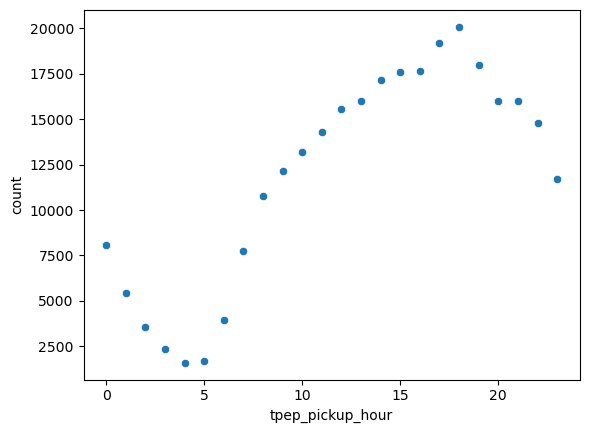

In [856]:
# Find and show the hourly trends in taxi pickups
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x=df_grouped['tpep_pickup_hour'], y=df_grouped['count'])
plt.show()

In [858]:
# Find and show the daily trends in taxi pickups (days of the week)
print(df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.weekday)['VendorID'].count())
grouped_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.weekday)['VendorID'].count()
df_grouped = grouped_df.reset_index()
print(df_grouped.columns)
df_grouped.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_day', 'VendorID': 'count'}, inplace=True)
print(df_grouped.columns)

tpep_pickup_datetime
0    35455
1    41137
2    43572
3    44608
4    42340
5    41431
6    35944
Name: VendorID, dtype: int64
Index(['tpep_pickup_datetime', 'VendorID'], dtype='object')
Index(['tpep_pickup_day', 'count'], dtype='object')


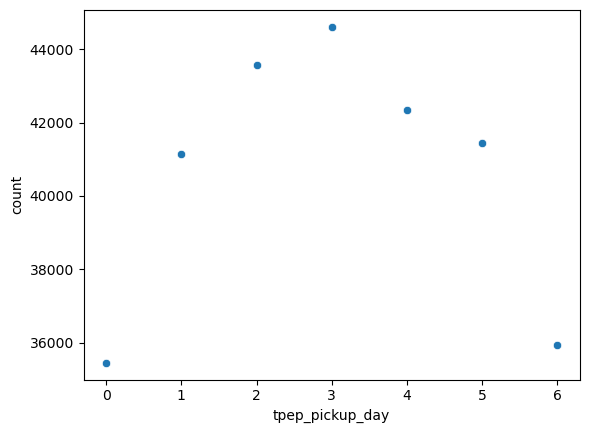

In [860]:
sns.scatterplot(x=df_grouped['tpep_pickup_day'], y=df_grouped['count'])
plt.show()

In [862]:
# Show the monthly trends in pickups

print(df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.month)['VendorID'].count())
grouped_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.month)['VendorID'].count()
df_grouped = grouped_df.reset_index()
print(df_grouped.columns)
df_grouped.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_month', 'VendorID': 'count'}, inplace=True)
print(df_grouped.columns)

tpep_pickup_datetime
1     22821
2     21686
3     25317
4     24443
5     26117
6     24554
7     21570
8     20954
9     21128
10    26134
11    24762
12    25001
Name: VendorID, dtype: int64
Index(['tpep_pickup_datetime', 'VendorID'], dtype='object')
Index(['tpep_pickup_month', 'count'], dtype='object')


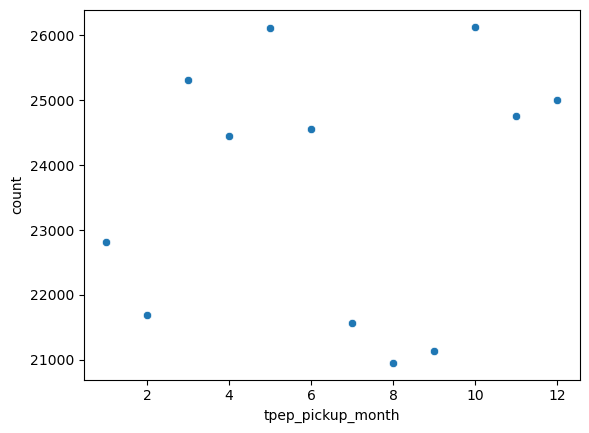

In [864]:
sns.scatterplot(x=df_grouped['tpep_pickup_month'], y=df_grouped['count'])
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [ ]:
# Analyse the above parameters



Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [ ]:
# Create a df with non zero entries for the selected parameters.

df_sampled_data has non-zero entries for selected parameters.

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [866]:
# Group data by month and analyse monthly revenue

print(df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.month)['total_amount'].sum())
grouped_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.month)['total_amount'].sum()
df_grouped = grouped_df.reset_index()
print(df_grouped.columns)
df_grouped.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_month', 'total_amount': 'sum_total_revenue'}, inplace=True)
print(df_grouped.columns)

tpep_pickup_datetime
1     627224.63
2     595059.00
3     713544.80
4     699357.96
5     769040.86
6     722962.78
7     621857.64
8     607662.35
9     638799.60
10    778678.16
11    714830.87
12    724719.07
Name: total_amount, dtype: float64
Index(['tpep_pickup_datetime', 'total_amount'], dtype='object')
Index(['tpep_pickup_month', 'sum_total_revenue'], dtype='object')


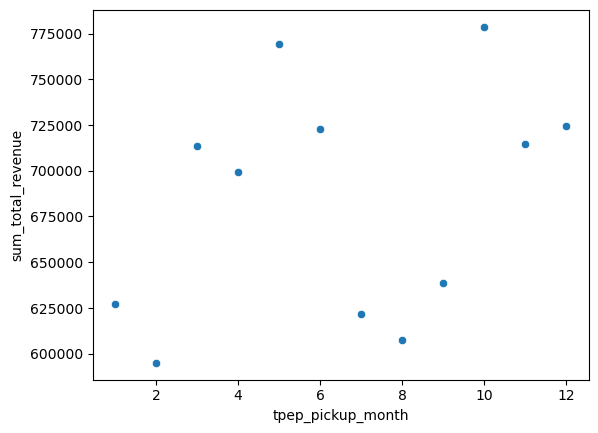

In [868]:
sns.scatterplot(x=df_grouped['tpep_pickup_month'], y=df_grouped['sum_total_revenue'])
plt.show()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [871]:
# Calculate proportion of each quarter
print(df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.quarter)['total_amount'].sum())
grouped_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.quarter)['total_amount'].sum()
df_grouped = grouped_df.reset_index()
print(df_grouped.columns)
df_grouped.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_quarter', 'total_amount': 'sum_total_revenue'}, inplace=True)
print(df_grouped.columns)


tpep_pickup_datetime
1    1935828.43
2    2191361.60
3    1868319.59
4    2218228.10
Name: total_amount, dtype: float64
Index(['tpep_pickup_datetime', 'total_amount'], dtype='object')
Index(['tpep_pickup_quarter', 'sum_total_revenue'], dtype='object')


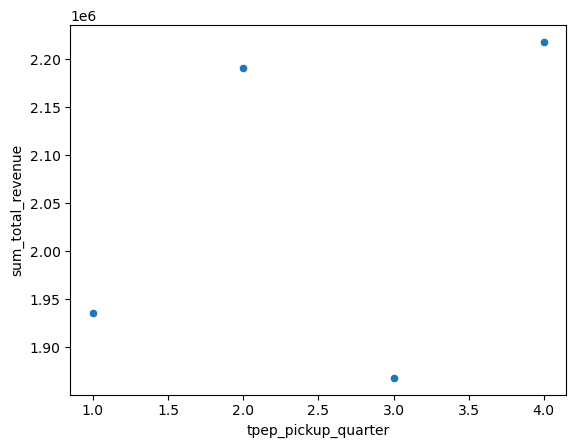

In [873]:
sns.scatterplot(x=df_grouped['tpep_pickup_quarter'], y=df_grouped['sum_total_revenue'])
plt.show()

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

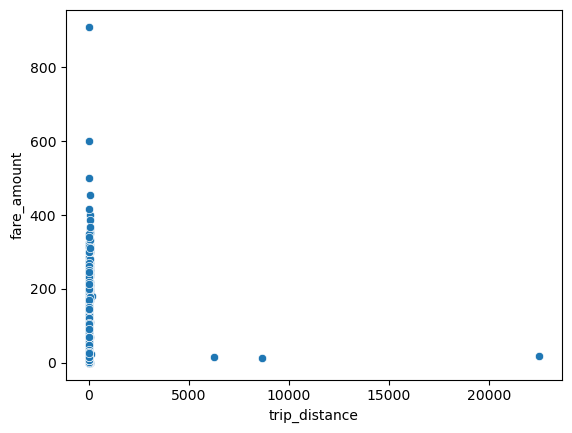

In [876]:
# Show how trip fare is affected by distance
df_sampled_data_dist_fare = df_sampled_data[df_sampled_data['trip_distance'] >= 1]
sns.scatterplot(x=df_sampled_data_dist_fare['trip_distance'], y=df_sampled_data_dist_fare['fare_amount'])
plt.show()


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

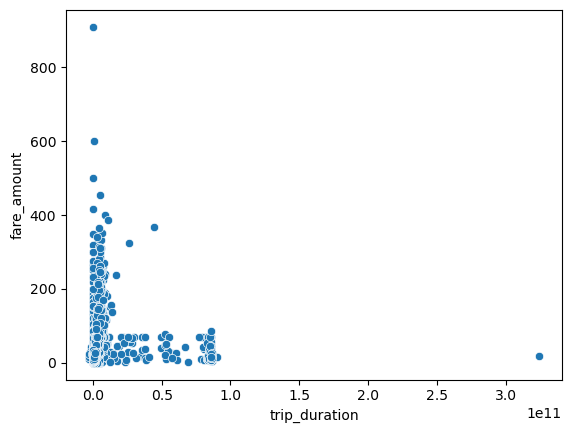

In [885]:
# Show relationship between fare and trip duration
df_sampled_data.loc[:,'trip_duration'] = df_sampled_data['tpep_dropoff_datetime'] - df_sampled_data['tpep_pickup_datetime']
sns.scatterplot(x=df_sampled_data['trip_duration'], y=df_sampled_data['fare_amount'])
plt.show()

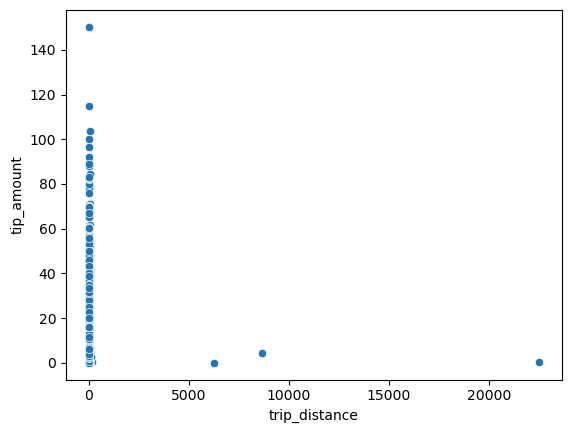

In [887]:
# Show relationship between fare and number of passengers
sns.scatterplot(x=df_sampled_data['trip_distance'], y=df_sampled_data['tip_amount'])
plt.show()

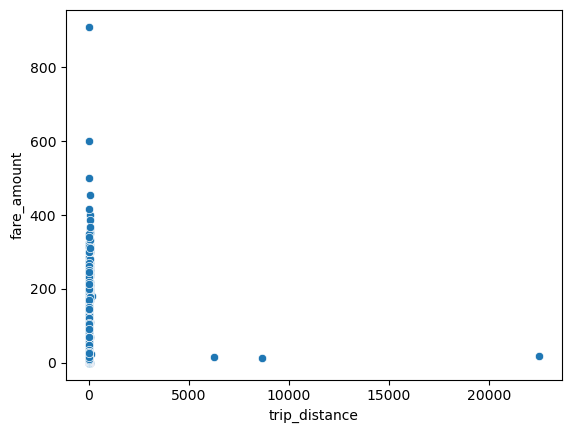

In [889]:
# Show relationship between tip and trip distance
sns.scatterplot(x=df_sampled_data['trip_distance'], y=df_sampled_data['fare_amount'])
plt.show()


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

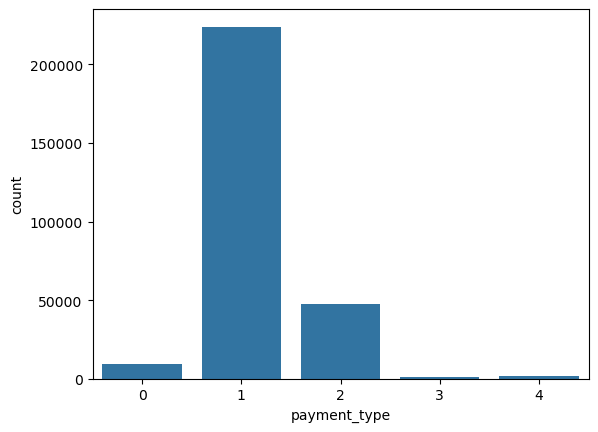

In [892]:
# Analyse the distribution of different payment types (payment_type).
sns.countplot(x=df_sampled_data['payment_type'])
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [898]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [901]:
# Read the shapefile using geopandas
# read the .shp file using gpd
import geopandas as gpd
zones = gpd.read_file('C:\\Ketan\\AI-ML\\upGrad\\EDA-Assignment\\datasets_NYC_taxi\\taxi_zones\\taxi_zones.shp') 
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zon'es in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None
(263, 7)


<Axes: >

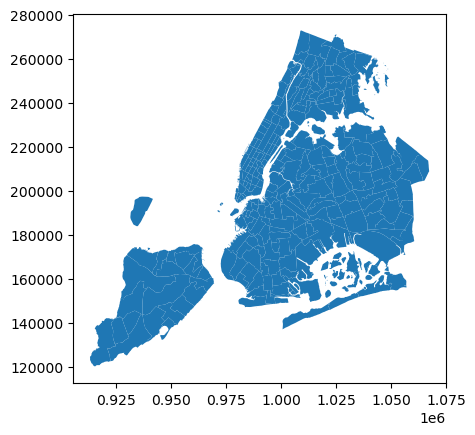

In [904]:
print(zones.info())
print(zones.shape)
zones.plot()

In [906]:
print(df_sampled_data.columns)
print(zones.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'trip_duration'],
      dtype='object')
Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry'],
      dtype='object')


Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [910]:
# Backup df_sampled_data into df_sampled_data_cp3
df_sampled_data_cp3 = df_sampled_data
print(df_sampled_data_cp3.shape)
print(df_sampled_data.shape)

(284487, 20)
(284487, 20)


In [914]:
print(zones.columns)
print(df_sampled_data.columns)

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry'],
      dtype='object')
Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'trip_duration'],
      dtype='object')


In [916]:
# Merge zones and trip records using locationID and PULocationID
print("\nMerged DataFrame:")
df_merged=pd.merge(df_sampled_data,zones, left_on='PULocationID',right_on='LocationID',how='inner')
print(df_merged)
#print(pd.merge(df_sampled_data,zones, left_on='PULocationID',right_on='LocationID',how='inner'))


Merged DataFrame:
        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0              2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1              2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2              2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3              2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4              2  2023-01-01 00:43:00   2023-01-01 01:01:00              1.0   
...          ...                  ...                   ...              ...   
281643         2  2023-09-30 22:20:44   2023-09-30 22:38:29              1.0   
281644         2  2023-09-30 22:40:34   2023-09-30 22:50:57              1.0   
281645         2  2023-09-30 22:36:57   2023-09-30 22:50:18              2.0   
281646         2  2023-09-30 22:48:49   2023-09-30 23:13:03              1.0   
281647         2  2023-09-30 22:07:53   2023-09-30 22:57:12              1.0   

        trip_distanc

In [920]:
#df_merged = df_sampled_data.merge(zones[['LocationID', 'zone', 'geometry']], on='LocationID')
#print(df_sampled_data.columns)
#print(zones.columns)
#df_merged1 = df_merged.reset_index()
#print(df_merged1.head())
print(df_merged.groupby(df_merged.LocationID).size())
#grouped_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.quarter)['total_amount'].sum()
#df_grouped = grouped_df.reset_index()
#print(df_grouped.columns)
#df_grouped.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_quarter', 'total_amount': 'sum_total_revenue'}, inplace=True)
#print(df_grouped.columns)


LocationID
1        40
3        10
4       339
5         1
6         3
       ... 
259       6
260      54
261    1494
262    3765
263    5466
Length: 241, dtype: int64


In [828]:
df1 = pd.DataFrame({'product_code': ['P001', 'P002', 'P003'],'store_location': ['New York', 'Los Angeles', 'Chicago'],'stock_quantity': [120, 150, 200]})
df2 = pd.DataFrame({'code': ['P001', 'P002', 'P004'],'store': ['New York', 'Los Angeles', 'Houston'],'price': [15.5, 20.0, 25.0]})

# Merging on multiple columns ('product_code' and 'store_location')
merged_df = pd.merge(df1, df2, left_on=['product_code', 'store_location'], right_on=['code', 'store'], how='inner')
print(merged_df)

  product_code store_location  stock_quantity  code        store  price
0         P001       New York             120  P001     New York   15.5
1         P002    Los Angeles             150  P002  Los Angeles   20.0


**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [776]:
# Group data by location and calculate the number of trips

#print(zones.groupby(zones.LocationID).count())
#grouped_df = zones.groupby(zones.LocationID).count()
#df_grouped = grouped_df.reset_index()
#print(df_grouped.columns)
#df_grouped.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_quarter', 'total_amount': 'sum_total_revenue'}, inplace=True)

geometry  OBJECTID  \
LocationID                                                                
1           POLYGON ((933100.918 192536.086, 933091.011 19...         1   
2           MULTIPOLYGON (((1020447.262 151454.148, 102035...         2   
3           POLYGON ((1026308.77 256767.698, 1026495.593 2...         3   
4           POLYGON ((992073.467 203714.076, 992068.667 20...         4   
5           POLYGON ((935843.31 144283.336, 936046.565 144...         5   
...                                                       ...       ...   
259         POLYGON ((1025414.782 270986.139, 1025138.624 ...       259   
260         POLYGON ((1011466.966 216463.005, 1011545.889 ...       260   
261         POLYGON ((980555.204 196138.486, 980570.792 19...       261   
262         MULTIPOLYGON (((999824.883 224487.553, 999867....       262   
263         POLYGON ((997493.323 220912.386, 997355.264 22...       263   

            Shape_Leng  Shape_Area                     zone        borough  
LocationID                                                                  
1             0.116357    0.000782           Newark Airport            EWR  
2             0.433470    0.004866              Jamaica Bay         Queens  
3             0.084341    0.000314  Allerton/Pelham Gardens          Bronx  
4             0.043567    0.000112            Alphabet City      Manhattan  
5             0.092146    0.000498            Arden Heights  Staten Island  
...                ...         ...                      ...            ...  
259           0.126750    0.000395       Woodlawn/Wakefield          Bronx  
260           0.133514    0.000422                 Woodside         Queens  
261           0.027120    0.000034       World Trade Center      Manhattan  
262           0.049064    0.000122           Yorkville East      Manhattan  
263           0.037017    0.000066           Yorkville West      Manhattan  

[260 rows x 6 columns]

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [947]:
# Merge trip counts back to the zones GeoDataFrame

df_loc_tr_cnt=pd.DataFrame()
df_loc_tr_cnt=df_merged.groupby(df_merged.LocationID).size().reset_index(name='trip_count')

print(df_loc_tr_cnt)
print(df_loc_tr_cnt.columns)

print("\nMerged DataFrame:")
df_zn_tr_cnt_merged=pd.merge(zones,df_loc_tr_cnt, on='LocationID',how='outer')
print(df_zn_tr_cnt_merged)

#df_merged1=df_merged.groupby(df_merged.LocationID)
#df_merged1=df_merged.groupby(df_merged.LocationID).size().to_frame('size')
#grouped_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.quarter)['total_amount'].sum()
#df_grouped = grouped_df.reset_index()
#df_merged = df_sampled_data.merge(zones[['LocationID', 'zone', 'geometry']], on='LocationID')
#print(df_sampled_data.columns)

     LocationID  trip_count
0             1          40
1             3          10
2             4         339
3             5           1
4             6           3
..          ...         ...
236         259           6
237         260          54
238         261        1494
239         262        3765
240         263        5466

[241 rows x 2 columns]
Index(['LocationID', 'trip_count'], dtype='object')

Merged DataFrame:
     OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0           1    0.116357    0.000782           Newark Airport           1   
1           2    0.433470    0.004866              Jamaica Bay           2   
2           3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3           4    0.043567    0.000112            Alphabet City           4   
4           5    0.092146    0.000498            Arden Heights           5   
..        ...         ...         ...                      ...         ...   
258       259    0.1267

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

In [1017]:
print('Display Zone-wise trips')

Display Zone-wise trips


After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

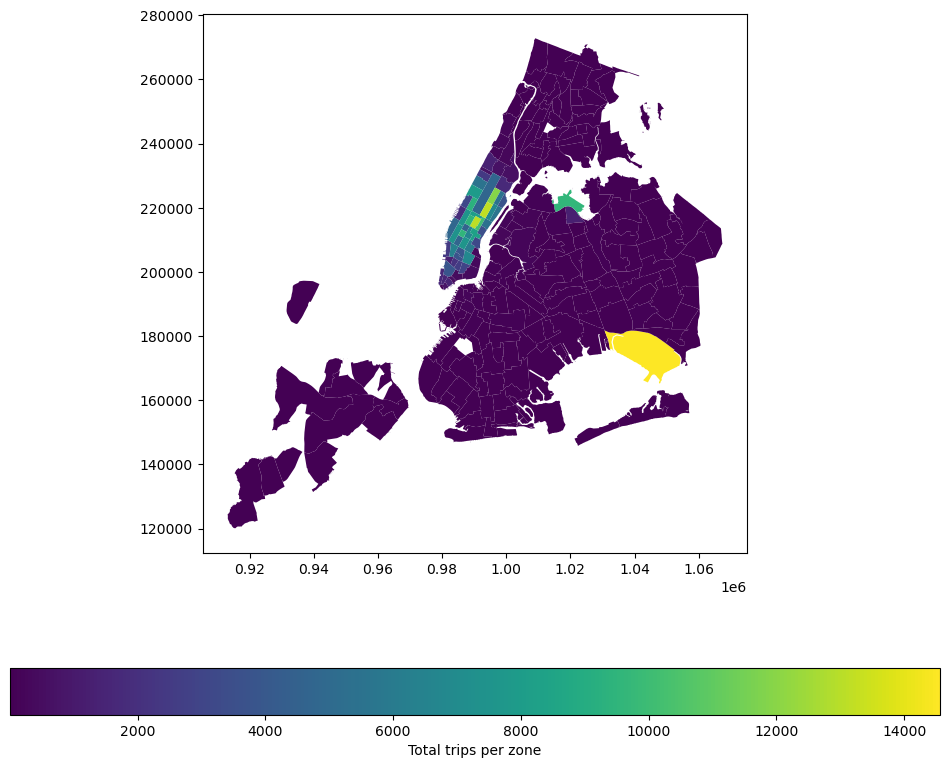

In [1015]:
# Define figure and axis

fig, ax = plt.subplots(1, 1, figsize = (12, 10))
# Plot the map and display it
df_zn_tr_cnt_merged.plot(column = 'trip_count', ax = ax, legend = True, legend_kwds = {'label': "Total trips per zone", 'orientation': "horizontal"})
plt.show()

In [979]:
# can you try displaying the zones DF sorted by the number of trips?
print(df_zn_tr_cnt_merged.sort_values("trip_count", axis=0, ascending=False))

     OBJECTID  Shape_Leng  Shape_Area                       zone  LocationID  \
131       132    0.245479    0.002038                JFK Airport         132   
236       237    0.042213    0.000096      Upper East Side South         237   
160       161    0.035804    0.000072             Midtown Center         161   
235       236    0.044252    0.000103      Upper East Side North         236   
161       162    0.035270    0.000048               Midtown East         162   
..        ...         ...         ...                        ...         ...   
175       176    0.151995    0.000658                    Oakwood         176   
182       183    0.039826    0.000095                 Pelham Bay         183   
183       184    0.260816    0.001989            Pelham Bay Park         184   
198       199    0.077809    0.000289              Rikers Island         199   
205       206    0.212757    0.000944  Saint George/New Brighton         206   

           borough                     

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [1099]:
# Find routes which have the slowest speeds at different times of the day
# Calculate the difference in minutes

df_sampled_data.loc[:,'time_diff_in_minutes'] = (df_sampled_data['tpep_dropoff_datetime'] - df_sampled_data['tpep_pickup_datetime']) / np.timedelta64(1, 'm')
grouped_hr_time_diff_df = df_sampled_data.groupby([df_sampled_data.tpep_pickup_datetime.dt.hour,'PULocationID', 'DOLocationID'],dropna=True)['time_diff_in_minutes'].mean()
df_grouped_hr_time_diff = grouped_hr_time_diff_df.reset_index()
df_grouped_hr_time_diff.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_hour'}, inplace=True)
print(df_grouped_hr_time_diff.columns)

df_grouped_hr_time_diff['Speed_Rank_by_hour'] = df_grouped_hr_time_diff.groupby(['tpep_pickup_hour', 'PULocationID', 'DOLocationID'])['time_diff_in_minutes'].rank(ascending=False)
print(df_grouped_hr_time_diff.shape)

# Rank the routes by the speeds at different times of the day.
#df_grouped_hr_time_diff['Speed_Rank_by_hour'] = df_grouped_hr_time_diff.groupby(['tpep_pickup_hour', 'PULocationID', 'DOLocationID'])['time_diff_in_minutes'].transform(lambda x: x.rank(ascending=False))
#print(df_grouped_hr_time_diff[df_grouped_hr_time_diff['Speed_Rank_by_hour'] == 1])
#df_grouped_hr_time_diff.to_csv('df_grouped_hr_time_diff.csv')

Index(['tpep_pickup_hour', 'PULocationID', 'DOLocationID',
       'time_diff_in_minutes'],
      dtype='object')
(65157, 5)


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

Index(['tpep_pickup_datetime', 'VendorID'], dtype='object')
Index(['tpep_pickup_hour', 'no_of_trips'], dtype='object')


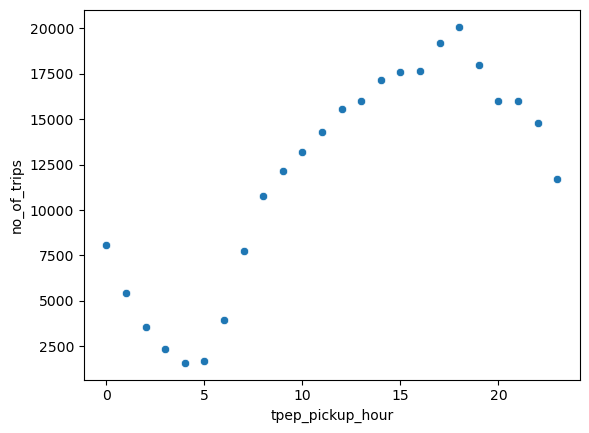

In [1109]:
# Visualise the number of trips per hour and find the busiest hour
grouped_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.hour)['VendorID'].count()
df_grouped = grouped_df.reset_index()
print(df_grouped.columns)
df_grouped.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_hour', 'VendorID': 'no_of_trips'}, inplace=True)
print(df_grouped.columns)

sns.scatterplot(x=df_grouped['tpep_pickup_hour'], y=df_grouped['no_of_trips'])
plt.show()
#Busiest hour is 18. i.e. 6pm

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

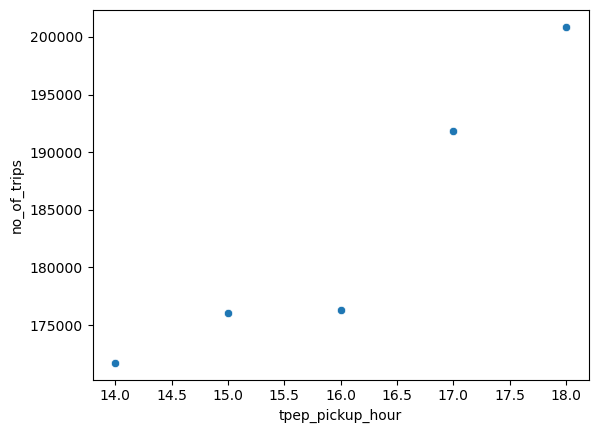

In [1131]:
# Scale up the number of trips
# Fill in the value of your sampling fraction and use that to scale up the numbers
df_grouped_busy_hr_scaled=df_grouped.query('tpep_pickup_hour >= 14 and tpep_pickup_hour <=18')

# Assuming sampling ratio of 0.1 scale up the numbers by 10.
df_grouped_busy_hr_scaled.loc[:, 'no_of_trips'] = 10 * df_grouped_busy_hr_scaled['no_of_trips']
sns.scatterplot(x=df_grouped_busy_hr_scaled['tpep_pickup_hour'], y=df_grouped_busy_hr_scaled['no_of_trips'])
plt.show()

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

tpep_pickup_datetime
0    35455
1    41137
2    43572
3    44608
4    42340
5    41431
6    35944
Name: VendorID, dtype: int64
Index(['tpep_pickup_datetime', 'VendorID'], dtype='object')
Index(['tpep_pickup_day', 'no_of_trips'], dtype='object')


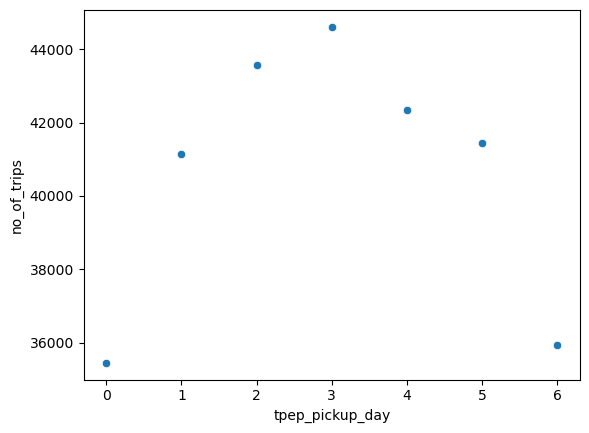

In [1135]:
# Compare traffic trends for the week days and weekends

print(df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.weekday)['VendorID'].count())
grouped_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.weekday)['VendorID'].count()
df_grouped = grouped_df.reset_index()
print(df_grouped.columns)
df_grouped.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_day', 'VendorID': 'no_of_trips'}, inplace=True)
print(df_grouped.columns)
sns.scatterplot(x=df_grouped['tpep_pickup_day'], y=df_grouped['no_of_trips'])
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [1237]:
# Find top 10 pickup and dropoff zones
grouped_hr_pk_time_df = df_sampled_data.groupby([df_sampled_data.tpep_pickup_datetime.dt.hour,'PULocationID'], dropna=True)['VendorID'].count()
df_grouped_hr_pk_time = grouped_hr_pk_time_df.reset_index()
df_grouped_hr_pk_time.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_hour', 'VendorID': 'no_of_trips'}, inplace=True)
df_grouped_hr_pk_time['Rank_by_hour'] = df_grouped_hr_pk_time['no_of_trips'].rank(method='dense', ascending=False)
print("\nTop 10 pickup zones :")
df_pk_merged=pd.merge(df_grouped_hr_pk_time, zones, left_on='PULocationID',right_on='LocationID',how='inner')
print(df_pk_merged[['tpep_pickup_hour', 'zone', 'borough', 'Rank_by_hour']].query('Rank_by_hour <= 10').sort_values('Rank_by_hour'))

grouped_hr_drp_time_df = df_sampled_data.groupby([df_sampled_data.tpep_dropoff_datetime.dt.hour,'DOLocationID'], dropna=True)['VendorID'].count()
df_grouped_hr_drp_time = grouped_hr_drp_time_df.reset_index()
df_grouped_hr_drp_time.rename(columns={'tpep_dropoff_datetime': 'tpep_dropoff_hour', 'VendorID': 'no_of_trips'}, inplace=True)
df_grouped_hr_drp_time['Rank_by_hour'] = df_grouped_hr_drp_time['no_of_trips'].rank(method='dense', ascending=False)
print("\nTop 10 dropoff zones :")
df_drp_merged=pd.merge(df_grouped_hr_drp_time, zones, left_on='DOLocationID',right_on='LocationID',how='inner')
print(df_drp_merged[['tpep_dropoff_hour', 'zone', 'borough', 'Rank_by_hour']].query('Rank_by_hour <= 10').sort_values('Rank_by_hour'))


Top 10 pickup zones :
      tpep_pickup_hour                   zone    borough  Rank_by_hour
2640                18         Midtown Center  Manhattan           1.0
2501                17         Midtown Center  Manhattan           2.0
2175                15            JFK Airport     Queens           3.0
2243                15  Upper East Side South  Manhattan           4.0
2354                16         Midtown Center  Manhattan           5.0
2545                17  Upper East Side South  Manhattan           6.0
2242                15  Upper East Side North  Manhattan           7.0
2333                16            JFK Airport     Queens           7.0
2755                19            JFK Airport     Queens           8.0
3107                22            JFK Airport     Queens           9.0
2682                18  Upper East Side South  Manhattan          10.0

Top 10 dropoff zones :
      tpep_dropoff_hour                   zone    borough  Rank_by_hour
3065                 15  Uppe

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [1287]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
#Count pickups per location pickup_counts = 
print(df_pk_merged[['PULocationID', 'zone']].value_counts().sort_values(ascending=False).head(10))
print(df_pk_merged[['PULocationID', 'zone']].value_counts().sort_values(ascending=True).head(10))

print(df_drp_merged[['DOLocationID', 'zone']].value_counts().sort_values(ascending=False).head(10))
print(df_drp_merged[['DOLocationID', 'zone']].value_counts().sort_values(ascending=True).head(10))

PULocationID  zone               
56            Corona                 32
142           Lincoln Square East    24
41            Central Harlem         24
141           Lenox Hill West        24
100           Garment District       24
24            Bloomingdale           24
4             Alphabet City          24
262           Yorkville East         24
261           World Trade Center     24
7             Astoria                24
Name: count, dtype: int64
PULocationID  zone                           
253           Willets Point                      1
5             Arden Heights                      1
204           Rossville/Woodrow                  1
221           Stapleton                          1
178           Ocean Parkway South                1
101           Glen Oaks                          1
120           Highbridge Park                    1
245           West Brighton                      1
154           Marine Park/Floyd Bennett Field    1
118           Heartland Village/Tod

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [1255]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
print(df_pk_merged[['tpep_pickup_hour', 'zone', 'borough', 'Rank_by_hour']].query('tpep_pickup_hour  >= 23 or tpep_pickup_hour  <=5').sort_values('Rank_by_hour').nsmallest(10, 'Rank_by_hour'))
print(df_drp_merged[['tpep_dropoff_hour', 'zone', 'borough', 'Rank_by_hour']].query('tpep_dropoff_hour >= 23 or tpep_dropoff_hour <=5').sort_values('Rank_by_hour').nsmallest(10, 'Rank_by_hour'))

      tpep_pickup_hour                       zone    borough  Rank_by_hour
3231                23                JFK Airport     Queens          15.0
55                   0                JFK Airport     Queens          69.0
3233                23          LaGuardia Airport     Queens          76.0
3208                23               East Village  Manhattan          86.0
33                   0               East Village  Manhattan          89.0
3288                23               West Village  Manhattan         111.0
109                  0               West Village  Manhattan         115.0
143                  1               East Village  Manhattan         122.0
3275                23  Times Sq/Theatre District  Manhattan         138.0
3236                23        Lincoln Square East  Manhattan         139.0
      tpep_dropoff_hour                   zone    borough  Rank_by_hour
4657                 23           East Village  Manhattan         112.0
4709                 23        

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [1340]:
# Filter for night hours (11 PM to 5 AM)
print('\nTotal revenue =', df_sampled_data['total_amount'].notnull().sum())

print('\nTotal revenue of night time hours =', df_sampled_data.query('tpep_pickup_datetime.dt.hour >= 23 or tpep_pickup_datetime.dt.hour <=5')['total_amount'].notnull().sum())
print('\nRevenue share of night time hours =', 
      str(round((df_sampled_data.query('tpep_pickup_datetime.dt.hour >= 23 or tpep_pickup_datetime.dt.hour <=5')['total_amount'].notnull().sum())/df_sampled_data['total_amount'].notnull().sum()*100, 2)) + '%')

print('\nTotal revenue of daytime hours =', df_sampled_data.query('tpep_pickup_datetime.dt.hour < 23 and tpep_pickup_datetime.dt.hour > 5')['total_amount'].notnull().sum())
print('\nRevenue share of daytime hours =', 
      str(round((df_sampled_data.query('tpep_pickup_datetime.dt.hour < 23 and tpep_pickup_datetime.dt.hour > 5')['total_amount'].notnull().sum())/df_sampled_data['total_amount'].notnull().sum()*100, 2)) + '%')


Total revenue = 284487

Total revenue of night time hours = 34372

Revenue share of night time hours = 12.08%

Total revenue of daytime hours = 250115

Revenue share of daytime hours = 87.92%


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [1391]:
# Analyse the fare per mile per passenger for different passenger counts
print(df_sampled_data.passenger_count.value_counts())
grouped_fare_permile_df = df_sampled_data.groupby(df_sampled_data.passenger_count, dropna=True)[['fare_amount', 'trip_distance']].sum()
df_grouped_fare_permile = grouped_fare_permile_df.reset_index()
df_grouped_fare_permile['fare_permile_per_passenger']=round(df_grouped_fare_permile['fare_amount']/(df_grouped_fare_permile['trip_distance'] * df_grouped_fare_permile['passenger_count']), 2)
print(df_grouped_fare_permile)

passenger_count
1.0    221058
2.0     41394
3.0     10386
4.0      5709
5.0      3547
6.0      2393
Name: count, dtype: int64
   passenger_count  fare_amount  trip_distance  fare_permile_per_passenger
0              1.0   4240748.55      768139.59                        5.52
1              2.0    923403.56      169787.22                        2.72
2              3.0    227932.18       40479.29                        1.88
3              4.0    133540.32       22922.57                        1.46
4              5.0     67010.55       11810.49                        1.13
5              6.0     44985.90        7937.91                        0.94


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [1405]:
# Compare the average fare per mile for different days and for different times of the day
print('\nAverage fare per mile for different times of the day\n')
grouped_avg_fare_permile_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.hour, dropna=True)[['fare_amount', 'trip_distance']].sum()
df_grouped_avg_fare_permile = grouped_avg_fare_permile_df.reset_index()
df_grouped_avg_fare_permile['fare_permile']=round(df_grouped_avg_fare_permile['fare_amount']/(df_grouped_avg_fare_permile['trip_distance']), 2)
print(df_grouped_avg_fare_permile)

print('\nAverage fare per mile for different days\n')
grouped_avg_fare_permile_days_df = df_sampled_data.groupby(df_sampled_data.tpep_pickup_datetime.dt.day, dropna=True)[['fare_amount', 'trip_distance']].sum()
df_grouped_avg_fare_permile_days = grouped_avg_fare_permile_days_df.reset_index()
df_grouped_avg_fare_permile_days['fare_permile']=round(df_grouped_avg_fare_permile_days['fare_amount']/(df_grouped_avg_fare_permile_days['trip_distance']), 2)
print(df_grouped_avg_fare_permile_days)



Average fare per mile for different times of the day

    tpep_pickup_datetime  fare_amount  trip_distance  fare_permile
0                      0    165687.39       31711.98          5.22
1                      1     99164.95       18431.26          5.38
2                      2     63471.50       11629.86          5.46
3                      3     42261.72        8079.00          5.23
4                      4     38698.67        7875.00          4.91
5                      5     48540.19       10847.37          4.47
6                      6     92422.04       19502.97          4.74
7                      7    152122.44       37221.02          4.09
8                      8    199875.30       34388.27          5.81
9                      9    227158.36       61098.17          3.72
10                    10    247862.61       41585.47          5.96
11                    11    274759.71       45198.70          6.08
12                    12    304981.22       49818.03          6.12
13     

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [1422]:
# Compare fare per mile for different vendors
print('\nAverage fare per mile for different vendors for different times of the day\n')
grouped_vendor_avg_fare_permile_df = df_sampled_data.groupby(['VendorID', df_sampled_data['tpep_pickup_datetime'].dt.hour], dropna=True)[['fare_amount', 'trip_distance']].sum()
df_grouped_vendor_avg_fare_permile = grouped_vendor_avg_fare_permile_df.reset_index()
df_grouped_vendor_avg_fare_permile['fare_permile']=round(df_grouped_vendor_avg_fare_permile['fare_amount']/(df_grouped_vendor_avg_fare_permile['trip_distance']), 2)
print(df_grouped_vendor_avg_fare_permile)


Average fare per mile for different vendors for different times of the day

    VendorID  tpep_pickup_datetime  fare_amount  trip_distance  fare_permile
0          1                     0     35481.93        6557.10          5.41
1          1                     1     21543.02        3899.20          5.52
2          1                     2     14374.19        2526.00          5.69
3          1                     3      9945.56        1837.90          5.41
4          1                     4      9652.53        1775.70          5.44
5          1                     5     13857.30        2971.30          4.66
6          1                     6     24582.84        4886.00          5.03
7          1                     7     44750.47        8120.70          5.51
8          1                     8     56110.76        9450.00          5.94
9          1                     9     60033.08        9836.40          6.10
10         1                    10     69260.32       11790.10          5.87

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [1436]:
# Defining distance tiers
print('\nAdd distance tiers')
df_sampled_data.loc[:, 'distance_tier']= np.where(df_sampled_data['trip_distance'] <= 2, 'upto_2miles',
                                  np.where(df_sampled_data['trip_distance'] <= 5, '2_to_5miles', 'more_than_5miles'))
print('\nCalculate average fare per mile for different vendors for different distance tiers\n')
grouped_vendor_avg_fare_permile_df = df_sampled_data.groupby(['VendorID', 'distance_tier'], dropna=True)[['fare_amount', 'trip_distance']].sum()
df_grouped_vendor_avg_fare_permile = grouped_vendor_avg_fare_permile_df.reset_index()
df_grouped_vendor_avg_fare_permile['fare_permile']=round(df_grouped_vendor_avg_fare_permile['fare_amount']/(df_grouped_vendor_avg_fare_permile['trip_distance']), 2)
print(df_grouped_vendor_avg_fare_permile.sort_values(['VendorID', 'distance_tier'], ascending=[True, False]))



Add distance tiers

Calculate average fare per mile for different vendors for different distance tiers

   VendorID     distance_tier  fare_amount  trip_distance  fare_permile
2         1       upto_2miles    500285.30       52317.10          9.56
1         1  more_than_5miles    543650.91      128816.30          4.22
0         1       2_to_5miles    365937.72       58450.70          6.26
5         2       upto_2miles   1231992.31      131314.49          9.38
4         2  more_than_5miles   1883407.75      476309.40          3.95
3         2       2_to_5miles   1112347.07      173869.08          6.40


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [1450]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
#print(df_sampled_data.columns)
print('\nCalculate average tip percentages based on distances, passenger counts and pickup times\n')
grouped_avg_tip_percent_df = df_sampled_data.groupby(['trip_distance', 'passenger_count', df_sampled_data['tpep_pickup_datetime'].dt.hour], dropna=True)[['total_amount', 'tip_amount']].sum()
df_grouped_avg_tip_percent = grouped_avg_tip_percent_df.reset_index()
df_grouped_avg_tip_percent.rename(columns={'tpep_pickup_datetime': 'tpep_pickup_hour'}, inplace=True)
df_grouped_avg_tip_percent['tip_percent']=round((df_grouped_avg_tip_percent['tip_amount']/df_grouped_avg_tip_percent['total_amount'])*100, 2)
print(df_grouped_avg_tip_percent.sort_values(['tpep_pickup_hour', 'passenger_count', 'trip_distance']))



Calculate average tip percentages based on distances, passenger counts and pickup times

       trip_distance  passenger_count  tpep_pickup_hour  total_amount  \
0               0.01              1.0                 0        129.66   
1               0.01              1.0                 1        109.70   
2               0.01              1.0                 2         34.55   
3               0.01              1.0                 3         54.97   
4               0.01              1.0                 4        228.80   
...              ...              ...               ...           ...   
60279         104.30              1.0                14         30.03   
60280         187.35              1.0                10        193.90   
60281        6284.45              1.0                22         20.00   
60282        8645.77              1.0                 7         21.68   
60283       22528.82              1.0                 9         21.79   

       tip_amount  tip_percent  


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%



**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [ ]:
# See how passenger count varies across hours and days




**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [ ]:
# How does passenger count vary across zones



In [ ]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.



Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [ ]:
# How often is each surcharge applied?



## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.